In [1]:
import matplotlib.pyplot as plt
from dsa_analysis import simulation, simulation_line, visualize, simulation_lorenz, combine_simulations, visualize, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity

%load_ext autoreload
%autoreload 2

The goal in this notebook is to study the impact of combining different shapes on the DSA metric. The idea is to create a dataset with different shapes and see how the DSA metric behaves when combining them.

## Parameters

#### Lorenz attractor simulation parameters

For each configuration, we simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [2]:
config = load_config('config.yaml')

## Compositionality

We here want to analyse the evolution of the dissimilarity as a function of the number of shared motifs

### Generation of the elementary motifs

We create here elementary motifs which will be repurposed as a basis for compositional motifs later

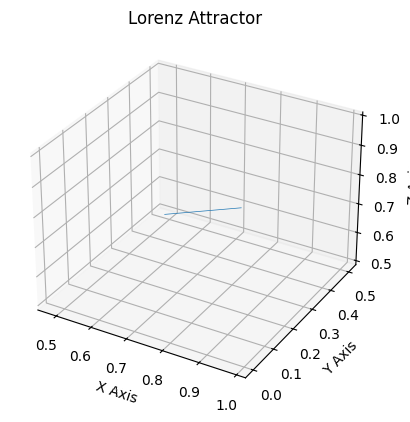

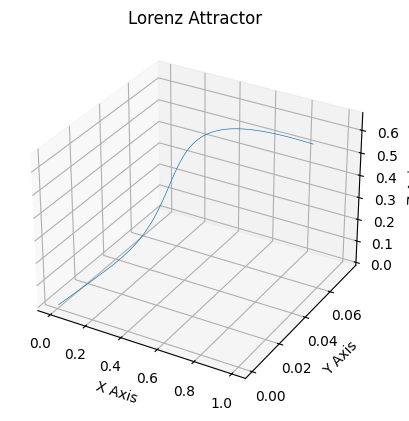

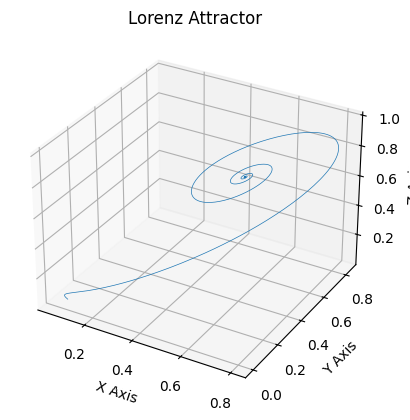

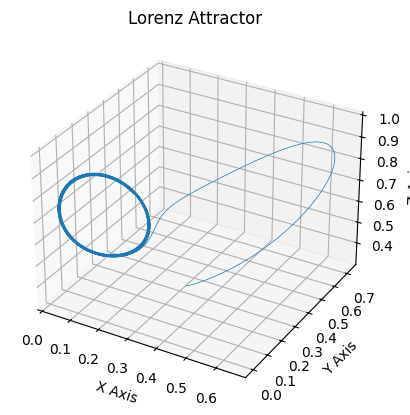

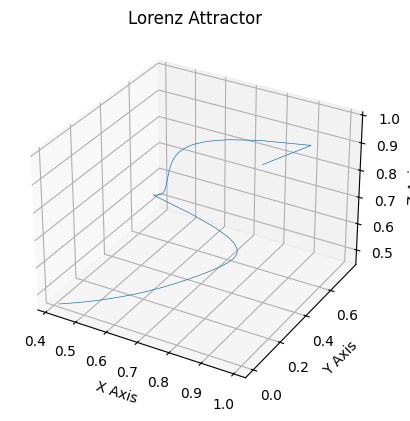

In [3]:
# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']

# Run simulations line
simulations_line = simulation_line(num_steps, num_samples)

# Run simulations curve
simulations_curve = simulation_lorenz(dt, lorenz_parameters['one_attractor'][1], num_samples, num_steps)

# Run simulations Pattern1
simulations_pattern1 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][0], num_samples, num_steps)

# Run simulations Pattern2
simulations_pattern2 = simulation_lorenz(dt, lorenz_parameters['two_stable_attractors'][2], num_samples, num_steps)

# Run simulations line-curve-line-curve
combined_simulations_line_curve_line = combine_simulations([simulations_line, simulations_curve, np.flip(simulations_line, axis=0), np.flip(simulations_curve, axis=0)], method='attach')


# Visualize the simulations
visualize([simulations_line[0]])
visualize([simulations_curve[0]])
visualize([simulations_pattern1[0]])
visualize([simulations_pattern2[0]])
visualize([combined_simulations_line_curve_line[0]])

### Generation of the possible compositional motifs

We here genetate all the possible permutations of $3$ different motifs among the $5$ elementary motifs. We hence have $5 \times 4 \times 3 = 60$ possible compositions.

In [4]:
combine_pattern_curve = combine_simulations([simulations_line, simulations_pattern1], method='attach')

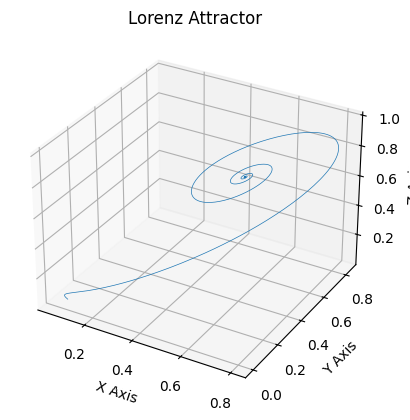

In [5]:
visualize([simulations_pattern1[0]])

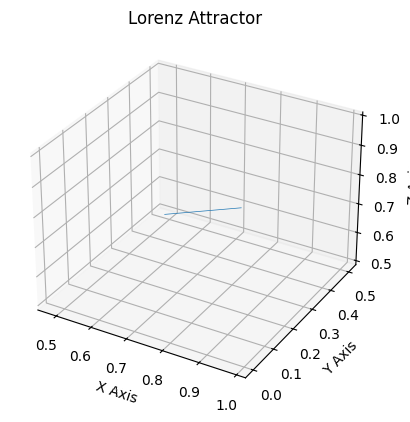

In [6]:
visualize([simulations_line[0]])

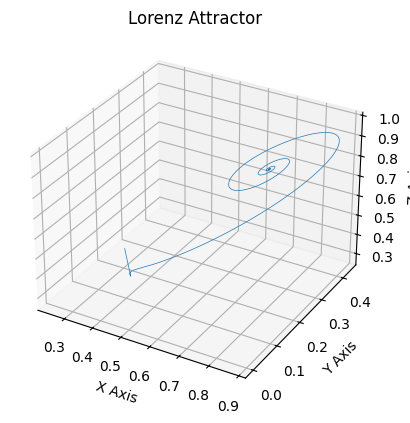

In [7]:
visualize([combine_pattern_curve[0]])

In [8]:
motif_basis = [simulations_line, simulations_curve, simulations_pattern1,simulations_pattern2,combined_simulations_line_curve_line]
motif_names = ['Line', 'Curve', 'Pattern1', 'Pattern2','Line-Curve-Line-Curve']
motif_dict = {motif_names[i]: motif_basis[i] for i in range(len(motif_basis))}
all_simulations_length_3 = list(permutations(motif_names, 3))

In [9]:
all_simulations_combined = {permutation: combine_simulations([motif_dict[permutation[0]], motif_dict[permutation[1]], motif_dict[permutation[2]]],method='attach') for permutation in all_simulations_length_3}

One out of $60$ possible combinations

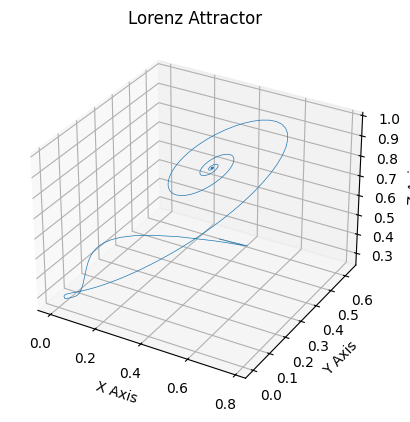

In [10]:
visualize([list(all_simulations_combined.values())[0][0]])

### DSA computation

We here measure the similarity between the 60 compositional motifs : 
- the three independant patterns, namely a line, curve and a lorenz pattern
- A combination of each 

In [11]:
model = list(all_simulations_combined.values())
model_names = list(all_simulations_combined.keys())

In [12]:
procrustes_measure = similarity.make("measure.sim_metric.cka-angular-score")
similarities_pa = np.empty((len(model),len(model)))
for i in range(len(model)):
    for j in range(len(model)):
        similarities_pa[i,j] = procrustes_measure(model[i], model[j])

arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.750692695862192 0.7216863673778988 0.249307304137808
arccos score: 0.5696777887393485 0.9646825722736011 0.4303222112606515
arccos score: 0.7309570212963085 0.7510730412076786 0.26904297870369154
arccos score: 0.5747604530794085 0.9584849383686013 0.4252395469205915
arccos score: 0.6930859088327923 0.8050351341351984 0.3069140911672077
arccos score: 0.5795326337447334 0.9526412445359153 0.4204673662552666
arccos score: 0.5090863757174854 1.0366733409148907 0.4909136242825146
arccos score: 0.6186259636561869 0.9038036675066149 0.38137403634381306
arccos score: 0.3664578481975762 1.1955971598316781 0.6335421518024238
arccos score: 0.7785207027906262 0.6784909665012988 0.22147929720937376
arccos score: 0.6132753186364908 0.9105957184916198 0.38672468136350924
arccos score: 0.09621170967000692 1.4744355616829377 0.9037882903299931
arccos score: 0.032993756469784086 1.5377965812897911 0.9670062435302159
arccos score: 0.010002

In [13]:
dsa = DSA.DSA(model,n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
similarities = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HA

KeyboardInterrupt: 

In [ ]:
np.save('data/similarities_5_motifs.npy', similarities)

### Dissimilarity VS number of shared elements

We group here the compositional motifs by number of shared elements

In [15]:
grouped_by_shared_elements = {i:[] for i in range(4)}
for comp_motif_1 in model_names:
    for comp_motif_2 in model_names:
        if model_names.index(comp_motif_1) != model_names.index(comp_motif_2):
            set_1 = set(comp_motif_1)
            set_2 = set(comp_motif_2)
            grouped_by_shared_elements[len(set_1.intersection(set_2))].extend([(comp_motif_1, comp_motif_2)])

In [16]:
# similarity of each tuple within grouped_by_shared_elements
#similarities_dsa_grouped_by_shared_elements = {i: [] for i in range(4)}
similarities_pa_grouped_by_shared_elements = {i:[] for i in range(4)}
for key in grouped_by_shared_elements:
    for tuple1, tuple2 in grouped_by_shared_elements[key]:
        #similarity_dsa = similarities[model_names.index(tuple1), model_names.index(tuple2)]
        similarity_pa = similarities_pa[model_names.index(tuple1), model_names.index(tuple2)]
        #similarities_dsa_grouped_by_shared_elements[key].append(similarity_dsa)
        similarities_pa_grouped_by_shared_elements[key].append(similarity_pa)

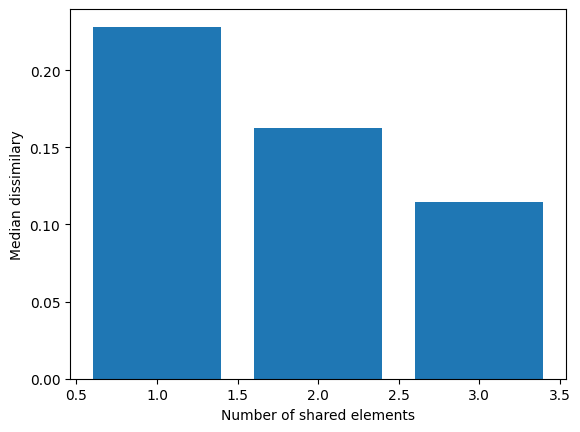

In [ ]:
# compute median of similarities for each group and plot similarity vs number of shared elements
median_similarities = {key: np.median(value) for key, value in similarities_dsa_grouped_by_shared_elements.items()}
plt.bar(median_similarities.keys(), median_similarities.values())
plt.xlabel('Number of shared elements')
plt.ylabel('Median dissimilary')

plt.show()


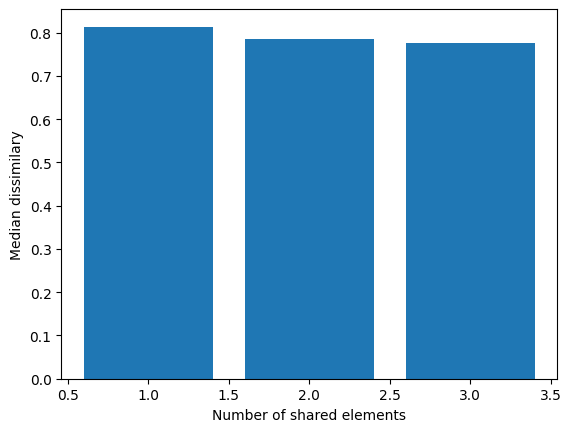

In [18]:
# compute median of similarities for each group and plot similarity vs number of shared elements
median_similarities = {key: 1-np.median(value) for key, value in similarities_pa_grouped_by_shared_elements.items()}
plt.bar(median_similarities.keys(), median_similarities.values())
plt.xlabel('Number of shared elements')
plt.ylabel('Median dissimilary')

plt.show()

In [ ]:
dsa = DSA.DSA(motif_basis,n_delays=config['dsa']['n_delays'],rank=config['dsa']['rank'],delay_interval=config['dsa']['delay_interval'],verbose=True,iters=1000,lr=1e-2)
similarities_basis = dsa.fit_score()

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 1 and 0
Finished optimizing C
Finished optimizing C
computing similarity between DMDs 2 and 0
Finishe

<Axes: >

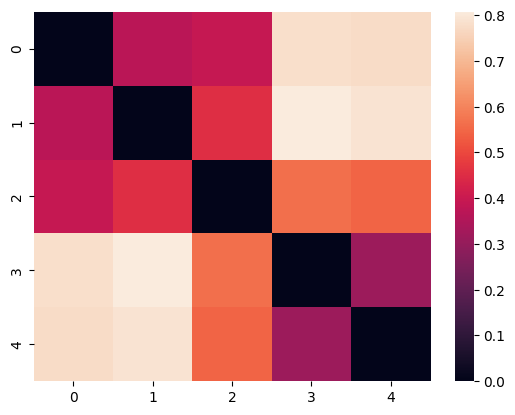

In [ ]:
sns.heatmap(similarities_basis)

In [19]:
similarities_basis_pa = np.empty((5,5))
for i in range(len(motif_basis)):
    for j in range(len(motif_basis)):
        similarities_basis_pa[i,j] = 1-procrustes_measure(motif_basis[i], motif_basis[j])


arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.0010118988769528547 1.5697844277452564 0.9989881011230471
arccos score: 0.00011620895794450803 1.5706801178366905 0.9998837910420555
arccos score: 5.866666511478158e-06 1.570790460128385 0.9999941333334885
arccos score: 0.3825541459726918 1.1782371796238675 0.6174458540273082
arccos score: 0.0010118988769528547 1.5697844277452564 0.9989881011230471
arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.4313085388895841 1.1248536723380271 0.5686914611104159
arccos score: 0.258259690437586 1.3095759806688712 0.741740309562414
arccos score: 0.30836244825130554 1.25732521507952 0.6916375517486945
arccos score: 0.00011620895794450803 1.5706801178366905 0.9998837910420555
arccos score: 0.4313085388895841 1.1248536723380271 0.5686914611104159
arccos score: 1.0 0.0 0.0
score is 1, returning 0
arccos score: 0.352016213872707 1.2110720046399397 0.647983786127293
arccos score: 0.08867349945178293 1.4820062077637681 0.911

<Axes: >

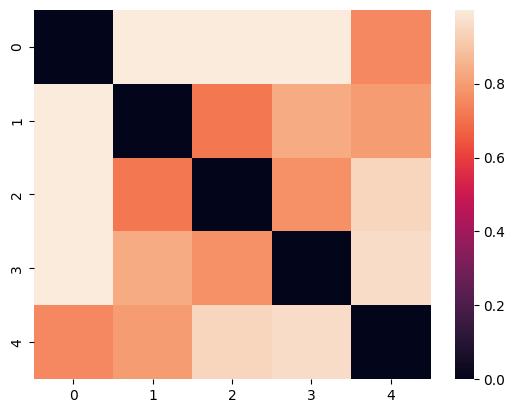

In [20]:
sns.heatmap(similarities_basis_pa)

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 